# Problem Overview

The goal of this playground is to analyze metastatic cancer given image patches from pathology scans. Essentially, for each `id` in the set, we need to predict a probability whether there is a pixel of tumor tissue or not at a center 32x32px region.

For this playground. I will be using a 3-layer CNN alongside a fully connected layer to predict the tumor pixel. While this is a smaller NN for cancer detection, it can start as a benchmark for larger models.

Created with PyTorch.

# Imports

In [1]:
import numpy as np 
import pandas as pd 
import torch
import matplotlib.pyplot as plt
import os
import tifffile as tiff
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split
from pathlib import Path
from typing import Literal, Callable
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
from collections import Counter
from tqdm.notebook import tqdm
from torchinfo import summary
from sklearn.metrics import precision_score, recall_score, f1_score
import torchvision.models as models

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Data EDA

We will take a look at the data first to understand what we are working with, then creat our dataset and showcase some images from the dataset.

There should be a healthy split of non-cancerous and cancerous tumor images. We should not have duplicates as well.

In [3]:
dirname = '/kaggle/input/histopathologic-cancer-detection'

train_df = pd.read_csv(f'{dirname}/train_labels.csv')

train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
print(f"No Cancer: {len(train_df[train_df['label'] == 0])}, Cancer: {len(train_df[train_df['label'] == 1])}")

No Cancer: 130908, Cancer: 89117


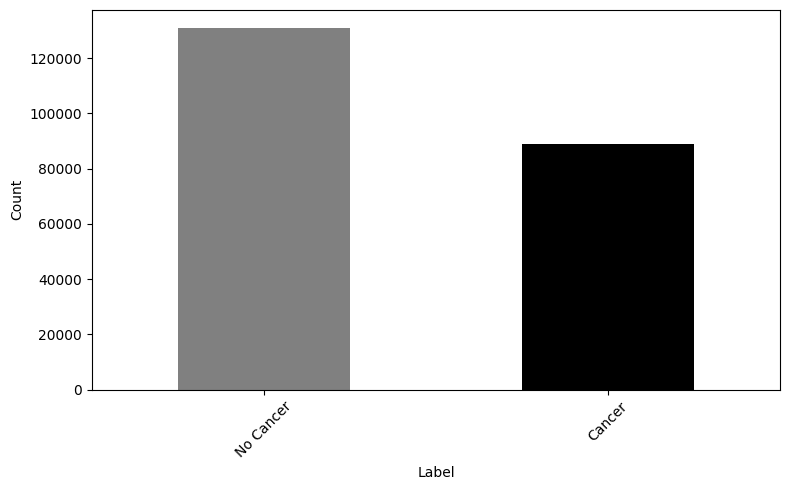

In [5]:
plt.figure(figsize=(8,5))
train_df['label'].map({1: 'Cancer', 0: 'No Cancer'}).value_counts().plot(kind='bar', color=['gray', 'black'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
train_imgs = os.listdir(f'{dirname}/train')
test_imgs = os.listdir(f'{dirname}/test')
print(f'Example Files: {train_imgs[:5]}')
print(f"Shape: {Image.open(os.path.join(dirname, 'train', train_imgs[0])).convert('RGB').size}")

Example Files: ['d43c081bafa286f9c1f7e921883f26ceafebc912.tif', '092d0eedebce504847715ee046b6ad74b57599b4.tif', 'b0d2582c6218a8764323fc940b41312282b99bf4.tif', '187c99df762f13f99818e5593d4bab4c6577e7e3.tif', '7c5270c83837de5a5cbb2dca511559dc39d19d53.tif']
Shape: (96, 96)


From this we know a couple facts about the dataset:
- About 60% of the dataset has no cancer, and 40% does.
- We are dealing with 96x96 RGB `tif` images 

Now, we need to create our dataset, inspect the images for any patterns for our model, and then create our model

## Dataset Creation

In [7]:
class CancerDS(Dataset):
    '''
        Custom dataset for histopathologic cancer detection images

        Args:
            data_dir: root directory of image data
            transform: transformation function to apply to the images
            imgs: list of the image filenames 
            labels: list of the labels (0 (no cancer) or 1 (cancer))
    '''
    def __init__(self, data_dir: str = "", transform: Callable = None, d_type: Literal['train', 'test'] = 'train'):
        self.data_dir = Path(data_dir)
        self.transform = transform

        # find images
        image_dir = self.data_dir / d_type
        if not image_dir.exists():
            raise FileNotFoundError(f'Directory {image_dir} not found')
    
        self.imgs = list(image_dir.glob('*.tif'))

        # find labels
        labels_dir = self.data_dir / 'train_labels.csv'
        if not labels_dir.exists():
            raise FileNotFoundError(f'Directory {labels_dir} not found')

        df = pd.read_csv(labels_dir).set_index('id')
        self.labels = [df.loc[img.stem].values[0] for img in self.imgs]
    
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        # open image
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        # apply transform if it exists
        if self.transform:
            img = self.transform(img)

        # return image, label, and the image name (the ID)
        img_id = img_path.stem
        return img, label, img_id

In [8]:
# Transform for training
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Transform for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# create dataset and split into train, testing
ds = CancerDS(dirname, transform_train, 'train')

indices = np.arange(len(ds))
train_indices, temp_indices = train_test_split(indices, test_size=0.3)
test_indices, val_indices = train_test_split(temp_indices, test_size=0.5)

train_ds = Subset(ds, train_indices)
test_ds = Subset(ds, test_indices)
val_ds = Subset(ds, val_indices)
test_ds.dataset.transform = transform_test
val_ds.dataset.transform = transform_test

In [9]:
print(f'Training: {len(train_ds)}, Testing: {len(test_ds)}, Validation: {len(val_ds)}')

Training: 154017, Testing: 33004, Validation: 33004


In [10]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True, num_workers=4, prefetch_factor=4, persistent_workers=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, pin_memory=True, num_workers=4, prefetch_factor=4, persistent_workers=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, pin_memory=True, num_workers=4, prefetch_factor=4, persistent_workers=True)

for indices in train_dl:
    print(indices[0].shape)
    break

torch.Size([32, 3, 96, 96])


## Example Images

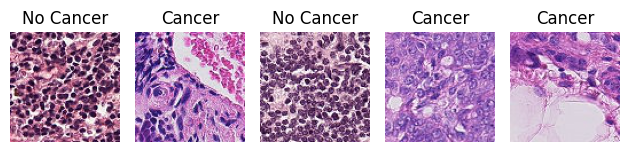

In [11]:
# showcasing a couple of the images from the dataset, without the normalization
example = next(iter(train_dl))

images = example[0]
labels = example[1]

fig, axes = plt.subplots(1, 5, sharex=True, sharey=True)
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

random_indices = torch.randint(low=0, high=32, size=(5,))
for i, num in enumerate(random_indices):
    # take out the normalization and reorganize so matplotlib can show the images
    img = images[num]
    img = img * std + mean
    img = img.permute(1, 2, 0)
    label = 'Cancer' if labels[num] == 1 else 'No Cancer'
    
    axes[i].set_title(label)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Model Creation

For this model, I chose to use 3 CNN layers, alongside fully connected layers for our classification purposes. Considering the limited GPU and CPU space, this will work well for our case.

We also have training and validation datasets to further ensure this model can attain a decent accuracy, and to analyze whether the mode is overfitting / underfitting. The model uses:
- Dropout layers for improving generalization / reducing overfitting
- Early stopping for prevention of overfitting (only save the model that does better to also prevent)
- Learning Rate Scheduler for avoiding local minimas (and better training results)

In [12]:
class CancerModel(nn.Module):
    def __init__(self):
        super(CancerModel, self).__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 32, 48 x 48

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 64, 24 x 24

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # 128, 12 x 12
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 12 * 12, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.convs(x)
        x = self.fc(x)
        return x

In [13]:
model = CancerModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

params = {
    'epochs': 25,
    'optimizer': optimizer,
    'lr_scheduler': lr,
    'weight_path': 'cnn1_weights.pt',
    'loss_fn': nn.BCELoss(),
    'patience': 7,
}

summary(model, input_size=(1, 3, 96, 96))

Layer (type:depth-idx)                   Output Shape              Param #
CancerModel                              [1, 1]                    --
├─Sequential: 1-1                        [1, 128, 12, 12]          --
│    └─Conv2d: 2-1                       [1, 32, 96, 96]           896
│    └─ReLU: 2-2                         [1, 32, 96, 96]           --
│    └─MaxPool2d: 2-3                    [1, 32, 48, 48]           --
│    └─Conv2d: 2-4                       [1, 64, 48, 48]           18,496
│    └─ReLU: 2-5                         [1, 64, 48, 48]           --
│    └─MaxPool2d: 2-6                    [1, 64, 24, 24]           --
│    └─Conv2d: 2-7                       [1, 128, 24, 24]          73,856
│    └─ReLU: 2-8                         [1, 128, 24, 24]          --
│    └─MaxPool2d: 2-9                    [1, 128, 12, 12]          --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Flatten: 2-10                     [1, 18432]                --
│    └

## Training / Testing of the Model

In [14]:
def train(model, dl, loss_fn, opt, device):
    model.train()
    for batch, (X, y, _) in enumerate(dl):
        X, y = X.to(device), y.to(device).float().unsqueeze(1)
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item()

def val(model, dl, loss_fn, device):
    model.eval()
    total_loss, corr = 0, 0
    with torch.no_grad():
        for X, y, _ in dl:
            X, y = X.to(device), y.to(device).float().unsqueeze(1)
            pred = model(X)
            total_loss += loss_fn(pred, y).item() * X.size(0)
            pred = (pred > 0.5).float() # binary output
            corr += (pred == y).sum().item()
    avg_loss = total_loss / len(dl.dataset)
    accuracy = corr / len(dl.dataset)
    return avg_loss, accuracy

def train_model(model, train_dl, val_dl, params, device):
    epochs = params['epochs']
    optimizer = params['optimizer']
    scheduler = params['lr_scheduler']
    weight_path = params['weight_path']
    loss_func = params['loss_fn']
    patience = params['patience']
    
    best_loss = float('inf')
    no_improve = 0
    total_train_loss = []
    total_val_loss = []
    
    for epoch in tqdm(range(epochs), desc='Training'):
        # training 
        print(f'Epoch {epoch+1}/{epochs}')
        train_loss = train(model, train_dl, loss_func, optimizer, device)
        val_loss, val_acc = val(model, val_dl, loss_func, device)
        print(f'Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')
        total_train_loss.append(train_loss)
        total_val_loss.append(val_loss)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            no_improve = 0
            torch.save(model.state_dict(), weight_path)
            print('New best model.')
        else:
            no_improve += 1
            if no_improve >= patience:
                print('Model might be overfitting. Stopping early...')
                break
    return total_train_loss, total_val_loss

In [15]:
train_losses, val_losses = train_model(model, train_dl, val_dl, params, device) 

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25
Training Loss: 0.0389, Validation Loss: 0.3231, Accuracy: 0.8738
New best model.
Epoch 2/25
Training Loss: 0.2051, Validation Loss: 0.2391, Accuracy: 0.9077
New best model.
Epoch 3/25
Training Loss: 0.6591, Validation Loss: 0.2360, Accuracy: 0.9130
New best model.
Epoch 4/25
Training Loss: 0.1165, Validation Loss: 0.2169, Accuracy: 0.9190
New best model.
Epoch 5/25
Training Loss: 0.2068, Validation Loss: 0.2208, Accuracy: 0.9125
Epoch 6/25
Training Loss: 0.2101, Validation Loss: 0.2391, Accuracy: 0.9217
Epoch 7/25
Training Loss: 0.0055, Validation Loss: 0.2142, Accuracy: 0.9230
New best model.
Epoch 8/25
Training Loss: 0.2467, Validation Loss: 0.2218, Accuracy: 0.9249
Epoch 9/25
Training Loss: 0.0148, Validation Loss: 0.2557, Accuracy: 0.9152
Epoch 10/25
Training Loss: 0.4608, Validation Loss: 0.2428, Accuracy: 0.9203
Epoch 11/25
Training Loss: 0.0402, Validation Loss: 0.2769, Accuracy: 0.9247
Epoch 12/25
Training Loss: 0.0000, Validation Loss: 0.2990, Accuracy: 0.9119
Epoch

## Model Outcomes

We can check the accuracy and how precise the model is with the loss and accuracy. However considering our dataset consists of about 40% cancer tumors, and 60% non-cancerous (a little imbalance will give a higher accuracy than wanted), we should use another metric to be more precise.
- Recall for missing cancer cases
- Precision for understanding false positives

In [16]:
best_model = CancerModel().to(device)
# best_model.load_state_dict(torch.load(params['weight_path'])) # -> if just trained data
best_model.load_state_dict(torch.load('/kaggle/input/cnn-cancerdetection-weights/cnn1_weights.pt', weights_only=True), strict=True) # when uploading weights previously trained
best_model.eval()
best_loss, best_acc = val(best_model, val_dl, params['loss_fn'], device)
print(f'Loss: {best_loss:.4}, Accuracy: {best_acc:.4}')

Loss: 0.1711, Accuracy: 0.9353


In [17]:
all_predictions = []
all_labels = []

with torch.no_grad():
    for X, y, _ in val_dl:
        X = X.to(device)
        y = y.to(device)
        preds = (best_model(X) > 0.5).float()

        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

prec = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print(f'Precision: {prec:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

Precision: 0.9365, Recall: 0.9009, F1: 0.9184


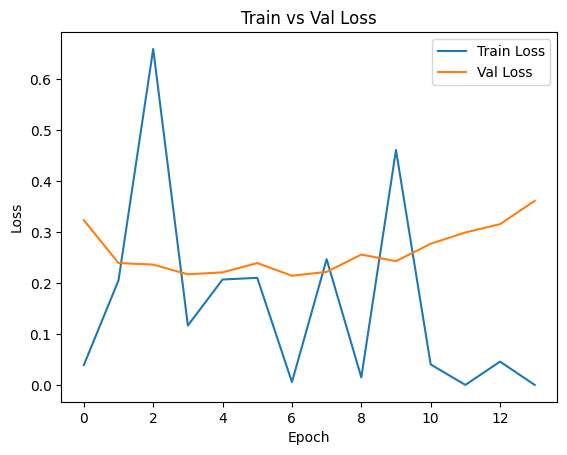

In [18]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Val Loss')
plt.legend()

From this, we can see a couple things
- When we detect cancer, we are 93% correct (7% false positive rate)
- Catch 90% of all cancer cases (10% false negative rate)
- 92% f1 score (well balanced)
- After Epoch 6, we started to overfit our model

Honestly this was not as good as what we were hoping for, as an AI in the medical field should not give out false positives 7% of the time, and failing to notice cancerous tumors 10% of the time.

There is room for improvement though, such as fine-tuning an existing model like **Resnet50** on the dataset, creating a deeper and more intricate CancerModel, or creating an ensemble method between the two.  

# Submission / Conclusion

The final result of this dataset was a score of 0.81, or 81% overall. Some improvements could be:
- Fine-tuning of more intricate image classification models
- More Pre-processing of images
- Modifying the CNN with more layers for feature extraction and perhaps more dropout layers for more generalization

I attempted to fine-tune a Resnet50 model on the data as well but it took far longer than wanted and did not show any promising results.

In [19]:
class TestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = Path(test_dir)
        self.image_ids = sorted(os.listdir(self.test_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = self.test_dir / image_id
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, image_id

In [20]:
test_dir = f"{dirname}/test"
batch_size = 64

test_dataset = TestDataset(test_dir, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

best_model.eval()
final_preds = []
final_ids = []

with torch.no_grad():
    for images, ids in test_loader:
        images = images.to(device)
        outputs = best_model(images)
        preds = (outputs > 0.5).float().squeeze().cpu().numpy()

        if preds.ndim == 0:
            preds = [preds.item()]
        else:
            preds = preds.tolist()

        final_preds.extend(preds)
        final_ids.extend([i.split('.')[0] for i in ids])

results_df = pd.DataFrame({
    'id': final_ids,
    'label': final_preds
})

results_df.to_csv('submission.csv', index=False)
results_df.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1.0
1,0000ec92553fda4ce39889f9226ace43cae3364e,1.0
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,1.0
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.0
4,000270442cc15af719583a8172c87cd2bd9c7746,0.0
